In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib notebook

In [96]:
cd ~/bmi_dynamics_code/

/Users/preeyakhanna/bmi_dynamics_code


In [97]:
from online_analysis import lds_utils

In [54]:
import numpy.random as npr
from pylds.models import DefaultLDS

D_obs = 1       # Observed data dimension
D_latent = 2 # Latent state dimension
D_input = 0    # Exogenous input dimension
T = 2000    # Number of time steps to simulate

true_model = DefaultLDS(D_obs, D_latent, D_input)
inputs = npr.randn(T, D_input)
data, stateseq = true_model.generate(T, inputs=inputs)

# Compute the log likelihood of the data with the true params
true_ll = true_model.log_likelihood() 

In [78]:
np.random.rand?

<IPython.core.display.Javascript object>


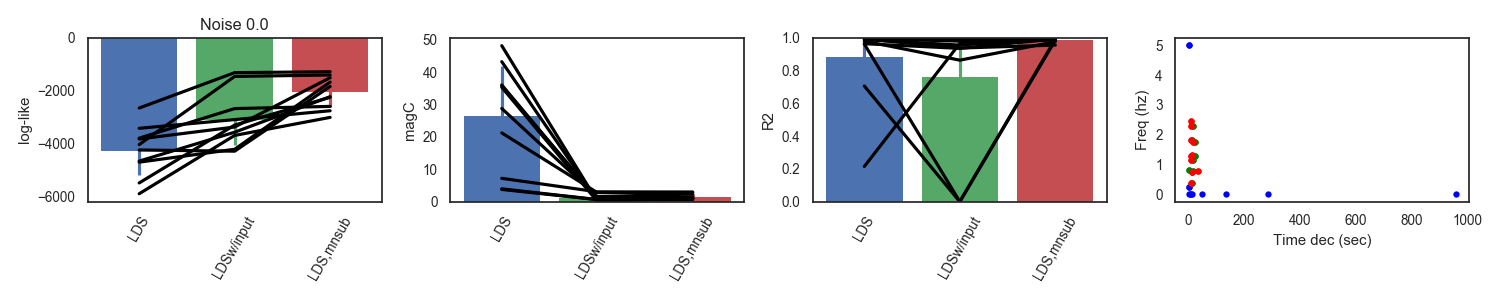

<IPython.core.display.Javascript object>


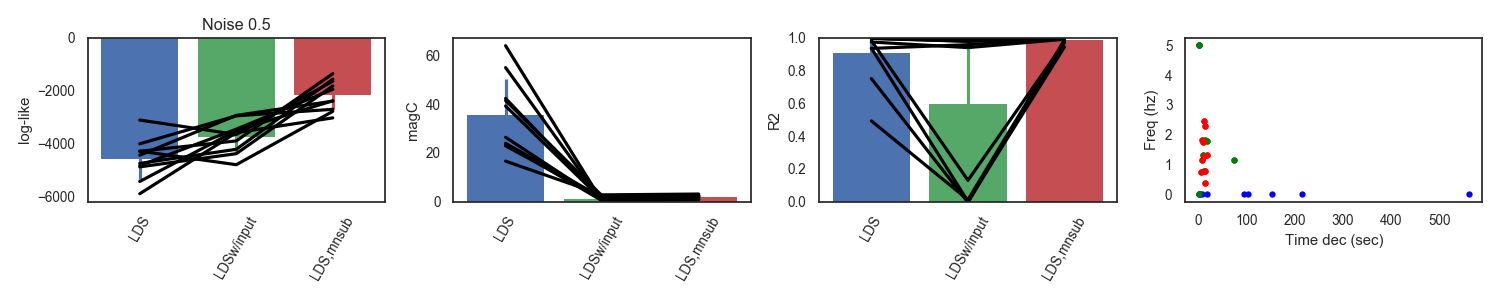

<IPython.core.display.Javascript object>


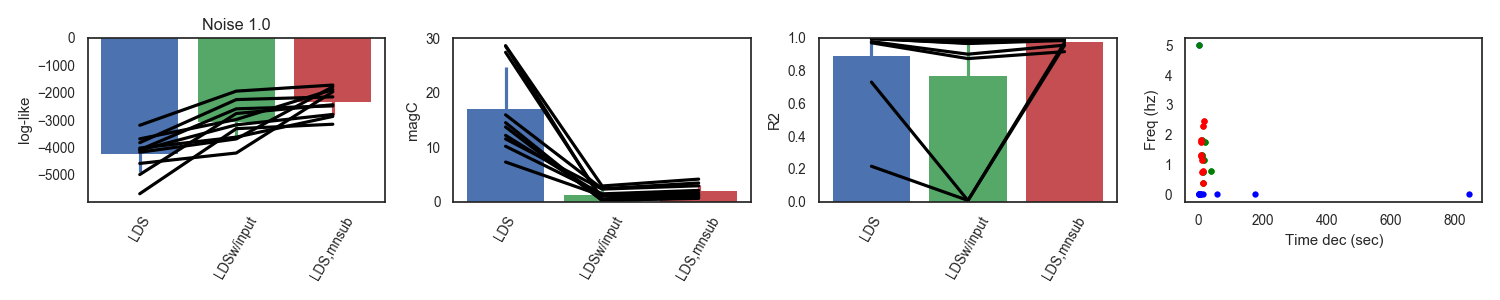

<IPython.core.display.Javascript object>


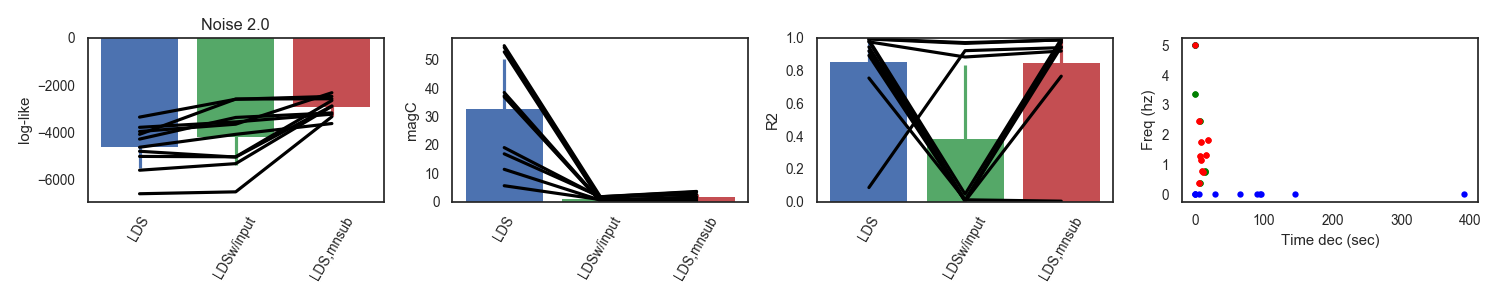

In [101]:
### Random offsets
# models = []
# for i in range(10): 
#     D_obs = 1       # Observed data dimension
#     D_latent = 2 # Latent state dimension
#     D_input = 0    # Exogenous input dimension
#     T = 2000    # Number of time steps to simulate
#     true_model = DefaultLDS(D_obs, D_latent, D_input)
#     inputs = npr.randn(T, D_input)
#     models.append(true_model) 

for ni, noise in enumerate([0, .5, 1., 2.]): 
    
    f, ax = plt.subplots(ncols = 4, figsize = (15, 3))
    ax[0].set_title('Noise %.1f'%(noise))

    LL = []; 
    magC = []; 
    R2 = [];
    
    eigs = [[],[],[]]
    
    for i in range(10):     
        
        D_input = 0
        inputs = npr.randn(T, D_input)

        ### Generate model ###
        data, stateseq = models[i].generate(T, inputs=inputs)
        data2, stateseq2 = models[i].generate(T, inputs=inputs)

        ### Add offset:
        offs = np.random.randint(-100, 100)
        
        ### Add offset and noise
        data = data + offs + noise*np.random.rand(T, D_obs)
        data2 = data2 + offs + noise*np.random.rand(T, D_obs)
        
        lli = []; 
        magCi = []; 
        r2i = []; 

        #f, axi =plt.subplots()
        #axi.plot(data2, 'k-')
        
        cols = ['b', 'g','r']
        for D_input in [0, 1, 2]: 
            
            if D_input in [0, 1]: 
                inputs = np.ones((T, D_input)) 

                test_model = DefaultLDS(D_obs, D_latent, D_input)
                test_model.add_data(data, inputs=inputs)

                # Run the Gibbs sampler
                N_samples = 100
                
                def update(model):
                    model.resample_model()
                    return model.log_likelihood()

                lls = [update(test_model) for _ in range(N_samples)]
                smoothed_data2 = test_model.smooth(data2, inputs)
            
            else: 
                test_model = DefaultLDS(D_obs, D_latent, 0)
                mean_data = np.mean(data)
                test_model.add_data(data - mean_data)

                # Run the Gibbs sampler
                N_samples = 100
                def update(model):
                    model.resample_model()
                    return model.log_likelihood()

                lls = [update(test_model) for _ in range(N_samples)]
                smoothed_data2 = test_model.smooth(data2 - mean_data) + mean_data
                
            #axi.plot(smoothed_data2, '-', linewidth=.5, color = cols[D_input])
        
            lli.append(lls[-1])
            magCi.append(np.sum(np.abs(test_model.C)))

            tmp = 1. - (float(np.sum((smoothed_data2 - data2)**2)) / float(np.sum((data2 - np.mean(data2))**2)))
            r2i.append(tmp)
    
            ## Eigenvalues ### 
            dt = 0.1
            _, evs = lds_utils.get_sorted_realized_evs(test_model.A)
            td = -1/np.log(np.abs(evs))*dt; 
            hz = np.angle(evs)/(2*np.pi*dt)
        
            ix_plot = np.nonzero(td >= 0.1)
            
            tmps = np.vstack((td[ix_plot][np.newaxis, :], hz[ix_plot][np.newaxis, :]))
            eigs[D_input].append(tmps)
    
        ### Plot ## 
        LL.append(np.hstack((lli)))
        magC.append(np.hstack((magCi)))
        R2.append(np.hstack((r2i)))

    for j, (met, metnm) in enumerate(zip([LL, magC, R2, eigs], ['log-like', 'magC', 'R2', 'eig'])): 
        ax[j].set_ylabel(metnm)
        if metnm == 'eig': 
            e0 = np.hstack((eigs[0]))
            e1 = np.hstack((eigs[1]))
            e2 = np.hstack((eigs[2]))
            for ie, eigi in enumerate([e0, e1, e2]): 
                ax[j].plot(eigi[0, :], np.abs(eigi[1, :]), '.', color=cols[ie])
            ax[j].set_xlabel('Time dec (sec)')
            ax[j].set_ylabel('Freq (hz)')
        else: 
            met = np.vstack((met))
            ax[j].set_xticks([0, 1, 2])
            ax[j].set_xticklabels(['LDS', 'LDSw/input', 'LDS,mnsub'], rotation=60)
            for k in [0, 1, 2]: 
                ax[j].bar(k, np.mean(met[:, k]))
                ax[j].errorbar(k, np.mean(met[:, k]),np.std(met[:, k]), marker='|')

            for k2 in range(met.shape[0]): 
                ax[j].plot([0, 1, 2], met[k2, :], 'k-')

    ax[2].set_ylim([0., 1.])
    f.tight_layout()
    f.savefig('/Users/preeyakhanna/bmi_dynamics_code/dynamics_sims/fit_LDS_deal_w_mean_noise%.1f.png'%noise)
    
        
        

In [86]:
pdb

Automatic pdb calling has been turned ON


In [59]:
# Create a separate model and add the observed data
test_model = DefaultLDS(D_obs, D_latent, D_input, B=np.zeros((D_latent, D_input)))
test_model.add_data(data)#, inputs=inputs)

# Run the Gibbs sampler
N_samples = 100
def update(model):
    model.resample_model()
    return model.log_likelihood()

lls = [update(test_model) for _ in range(N_samples)]

In [65]:
test_model.C

array([[ 27.95572082, -31.60628741]])

<IPython.core.display.Javascript object>


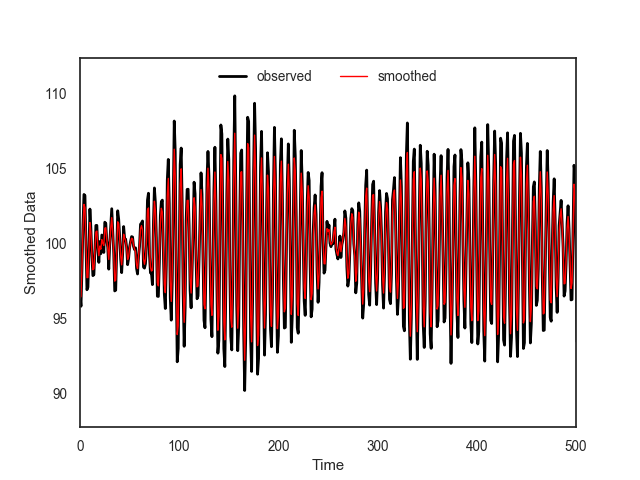

In [62]:
# Smooth the data
smoothed_data = test_model.smooth(data, inputs)
colors = ['k','r']
plt.figure()
plt.plot(data, color=colors[0], lw=2, label="observed")
plt.plot(smoothed_data, color=colors[1], lw=1, label="smoothed")
plt.xlabel("Time")
plt.xlim(0, 500)
plt.ylabel("Smoothed Data")
plt.legend(loc="upper center", ncol=2)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])